In [16]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using Interpolations
using LinearAlgebra
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude("../Hofstadter Many Body Utils.ipynb")
@nbinclude(joinpath("../Braiding Utils.ipynb"))
@nbinclude("Torus_Distance.ipynb");

In [17]:
Nx=8
Ny=10
N=Nx*Ny
p=1
q=Ny
NPhi = Int( Nx * Ny * (p/q) )
cut_off = NPhi
PN = [0, 1, 2, 3]
U=2;

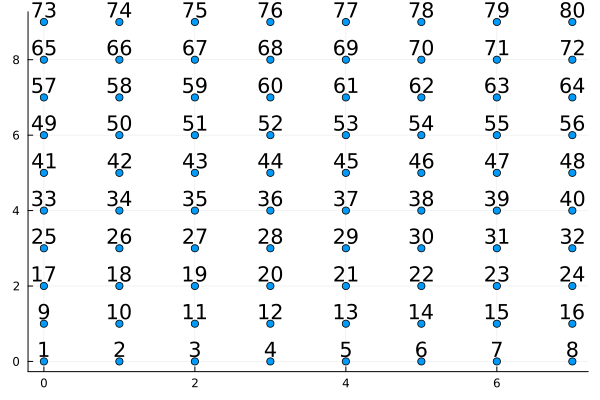

In [18]:
plot_square_lattice(Nx, Ny)

In [21]:
V_Strength = 4
V0 = [V_Strength, 
      0*V_Strength]; 
Imp_Site = [40, 91]
N_Pin = 1 # Number of pinning quasihole
Impurity_Data = Impurity(V0, Imp_Site)
factor = 5; # particle density interpolation factor

In [28]:
H1, sp_basis = H_sp(N, Nx, Ny, p, q)
    H1_sub, basis_sub, P, Pt = H_sub(N, Nx, Ny, p, q, H1, cut_off, sp_basis)
    basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off, PN)
    H_Kin, Total_H = H_Total_Sub(basis_cut_mb, basis_sub, PN, H1_sub, P, Pt, cut_off, U)
Sub_Number_MB_Operator_List = Number_sub(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub)
    H_Impurity = get_H_Impurity(N, sp_basis, P, Pt, basis_cut_sp, basis_cut_mb, basis_sub, Total_H, Sub_Number_MB_Operator_List, Impurity_Data)
    #E, V = energies_imp(H_Impurity, PN, basis_cut_mb)

0.0%┣                                                ┫ 0/8 [00:00<00:00, -0s/it]
25.0%┣███████████▊                                   ┫ 2/8 [00:00<00:00, 19it/s]
50.0%┣███████████████████████▌                       ┫ 4/8 [00:00<00:00, 29it/s]
75.0%┣███████████████████████████████████▎           ┫ 6/8 [00:00<00:00, 30it/s]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 30it/s]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 30it/s]
0.0%┣                                               ┫ 0/80 [00:00<00:00, -0s/it]
100.0%┣████████████████████████████████████████┫ 80/80 [00:00<00:00, 432.5kit/s]
100.0%┣████████████████████████████████████████┫ 80/80 [00:00<00:00, 336.8kit/s]


LoadError: BoundsError: attempt to access 80-element Vector{Operator{ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0x124640f659a80575, UInt64}, ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0x124640f659a80575, UInt64}, SparseMatrixCSC{ComplexF64, Int64}}} at index [91]

In [23]:
get_energies_and_density(N, Nx, Ny, p, q, cut_off, PN, U, Impurity_Data, N_Pin);

0.0%┣                                                ┫ 0/8 [00:00<00:00, -0s/it]
25.0%┣███████████▊                                   ┫ 2/8 [00:00<00:00, 14it/s]
50.0%┣███████████████████████▌                       ┫ 4/8 [00:00<00:00, 19it/s]
75.0%┣███████████████████████████████████▎           ┫ 6/8 [00:00<00:00, 22it/s]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 24it/s]
100.0%┣██████████████████████████████████████████████┫ 8/8 [00:00<00:00, 24it/s]
0.0%┣                                               ┫ 0/80 [00:00<00:00, -0s/it]
1.2%┣▌                                          ┫ 1/80 [00:00<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 80/80 [00:00<00:00, 1.4kit/s]
100.0%┣██████████████████████████████████████████┫ 80/80 [00:00<00:00, 1.4kit/s]


LoadError: BoundsError: attempt to access 80-element Vector{Operator{ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0x124640f659a80575, UInt64}, ManyBodyBasis{Vector{Int64}, NLevelBasis{Int64}, 0x124640f659a80575, UInt64}, SparseMatrixCSC{ComplexF64, Int64}}} at index [91]

In [20]:
ref_site = 36 # Site Pinned (Site 44 = Site 36) # BURASI GENEL DEĞİL SORUN YARATABİLİR!!!

36